<a href="https://colab.research.google.com/github/springboardmentor789r/AgriYield/blob/Intern_SaniyaMariyam/AgriYield_Predictor(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

df = pd.read_excel('crop_yield_dataset.xlsx')

df.head(10)

Saving crop_yield_dataset.xlsx to crop_yield_dataset.xlsx


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,Wheat,Peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,2014-01-01,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2014-01-01,Rice,Peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
3,2014-01-01,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
4,2014-01-01,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667
5,2014-01-01,Cotton,Sandy,6.75,14.826739,80.000000,10.366657,55.0,44.0,36.0,29.356115,39.375000
6,2014-01-01,Sugarcane,Saline,8.00,13.533004,80.000000,9.910484,84.5,66.0,54.0,0.000000,17.041667
7,2014-01-01,Tomato,Clay,6.25,18.323272,80.000000,8.198084,60.0,45.0,40.0,22.221375,42.291667
8,2014-01-01,Potato,Peaty,5.50,18.895963,80.000000,6.696707,60.5,45.0,31.5,54.259727,22.833333
9,2014-01-01,Sunflower,Loamy,6.50,16.865595,80.000000,9.311649,70.0,66.0,55.0,68.119250,63.666667


In [4]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00


In [5]:
!pip install openpyxl

In [6]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

print("Original Data Shape:", df.shape)

# Detect and remove rows where Crop_Yield == 0 ---
target_col = None
for col in df.columns:
    if "yield" in col.lower():
        target_col = col
        break

if target_col is None:
    raise ValueError("No column containing 'yield' found in dataset!")

df = df[df[target_col] != 0].reset_index(drop=True)
print(f"After removing rows with {target_col} = 0 → Shape: {df.shape}\n")

# Identify categorical and numerical columns ---
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("Categorical Columns:", categorical_cols.tolist())
print("Numerical Columns:", numerical_cols.tolist(), "\n")

# Apply Leave-One-Out Encoding ---
loo_encoder = LeaveOneOutEncoder(cols=categorical_cols)
loo_encoded_df = df.copy()
loo_encoded_df[categorical_cols] = loo_encoder.fit_transform(df[categorical_cols], df[target_col])

print("Leave-One-Out Encoding Applied Successfully!\n")

# Display Sample of Encoded Data ---
print("Preview of Leave-One-Out Encoded Data:")
print(loo_encoded_df.head())


Original Data Shape: (36520, 12)
After removing rows with Crop_Yield = 0 → Shape: (25495, 12)

Categorical Columns: ['Crop_Type', 'Soil_Type']
Numerical Columns: ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality'] 

Leave-One-Out Encoding Applied Successfully!

Preview of Leave-One-Out Encoded Data:
        Date  Crop_Type  Soil_Type  Soil_pH  Temperature   Humidity  \
0 2014-01-01  40.966442  52.501041     6.50    20.052576  79.947424   
1 2014-01-01  37.007957  33.402460     6.75    19.751848  80.000000   
2 2014-01-01  36.923115  31.327259     5.50    16.110395  80.000000   
3 2014-01-01  41.984588  33.408309     6.75    14.826739  80.000000   
4 2014-01-01  32.445278  41.611338     6.25    18.323272  80.000000   

   Wind_Speed     N     P     K  Crop_Yield  Soil_Quality  
0    8.591577  84.0  66.0  50.0  104.871310     66.666667  
1    2.682683  50.0  40.0  30.0   58.939796     35.000000  
2    7.696070  49.5  45.0  38.5   32.970413   

In [7]:
from openpyxl import Workbook

# Save the single Leave-One-Out encoded dataset
output_path = "loo_encoded_dataset.xlsx"
loo_encoded_df.to_excel(output_path, index=False)

print(f" Leave-One-Out encoded dataset saved as: {output_path}")

# If using Google Colab, download the file automatically
from google.colab import files
files.download(output_path)


 Leave-One-Out encoded dataset saved as: loo_encoded_dataset.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

R² = 0.9997 | RMSE = 0.3933 | MAE = 0.1598


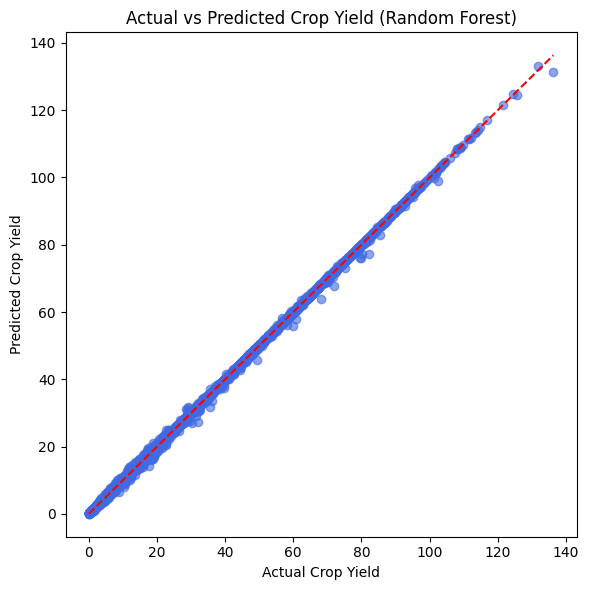

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import LeaveOneOutEncoder

# Load dataset
df = pd.read_excel("loo_encoded_dataset.xlsx")

# Identify target column (crop yield)
target = next((c for c in df.columns if "yield" in c.lower()), None)

# Drop rows with zero yield
df = df[df[target] != 0].reset_index(drop=True)

# Convert datetime columns to year
for c in df.select_dtypes(include=['datetime64']):
    df[c] = pd.to_datetime(df[c]).dt.year

# Split into features and target
X = df.drop(columns=[target])
y = df[target]

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns

# Apply Leave-One-Out encoding manually
encoder = LeaveOneOutEncoder(cols=cat_cols)
X_encoded = encoder.fit_transform(X, y)

# Train-test split
Xtr, Xte, ytr, yte = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(Xtr, ytr)

# Predict on test set
yp = model.predict(Xte)

# Evaluate model
r2 = r2_score(yte, yp)
rmse = np.sqrt(mean_squared_error(yte, yp))
mae = mean_absolute_error(yte, yp)

print(f"R² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(yte, yp, alpha=0.6, c='royalblue')
lim = [min(yte.min(), yp.min()), max(yte.max(), yp.max())]
plt.plot(lim, lim, 'r--')
plt.xlabel("Actual Crop Yield")
plt.ylabel("Predicted Crop Yield")
plt.title("Actual vs Predicted Crop Yield (Random Forest)")
plt.tight_layout()
plt.show()


In [11]:
# Sample Test Prediction
sample_X = Xte.iloc[[0]]        # Take one test sample
sample_y = yte.iloc[0]          # Actual crop yield for that sample

# Predict crop yield for that sample
pred_y = model.predict(sample_X)[0]

print("\n--- Sample Test Prediction ---")
print(f"Actual Crop Yield    : {sample_y:.4f}")
print(f"Predicted Crop Yield : {pred_y:.4f}")



--- Sample Test Prediction ---
Actual Crop Yield    : 17.6036
Predicted Crop Yield : 17.8063


R²=0.9997 | RMSE=0.3933 | MAE=0.1598


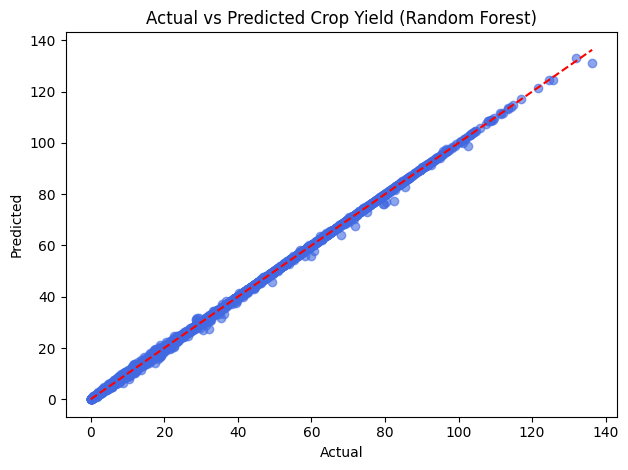

In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import LeaveOneOutEncoder

# Load & prepare data
df = pd.read_excel("loo_encoded_dataset.xlsx")
target = next((c for c in df.columns if "yield" in c.lower()), None)
df = df[df[target] != 0].reset_index(drop=True)
for c in df.select_dtypes(include=['datetime64']): df[c] = pd.to_datetime(df[c]).dt.year

X, y = df.drop(columns=[target]), df[target]
cat_cols = X.select_dtypes(include=['object']).columns
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline + model
pipe = Pipeline([
    ("prep", ColumnTransformer([("loo", LeaveOneOutEncoder(cols=cat_cols), cat_cols)], remainder='passthrough')),
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
]).fit(Xtr, ytr)

# Evaluation
yp = pipe.predict(Xte)
r2, rmse, mae = r2_score(yte, yp), np.sqrt(mean_squared_error(yte, yp)), mean_absolute_error(yte, yp)
print(f"R²={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")

# Plot regression line
plt.scatter(yte, yp, alpha=0.6, c='royalblue'); lim=[min(yte.min(), yp.min()), max(yte.max(), yp.max())]
plt.plot(lim, lim, 'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Actual vs Predicted Crop Yield (Random Forest)"); plt.tight_layout(); plt.show()


In [9]:
# Sample Test Prediction
sample_X = Xte.iloc[[0]]
sample_y = yte.iloc[0]

# Predict crop yield for that sample
pred_y = pipe.predict(sample_X)[0]

print("\n Sample Test Prediction ")
print(f"Actual Crop Yield : {sample_y:.4f}")
print(f"Predicted Crop Yield : {pred_y:.4f}")



 Sample Test Prediction 
Actual Crop Yield : 17.6036
Predicted Crop Yield : 17.8063
